In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import pandas as pd
import scipy.sparse as ssp
from functools import lru_cache
from tqdm import tqdm, trange

import xgboost as xgb 
from sklearn.model_selection import GroupKFold
import time
import matplotlib.pyplot as plt

In [2]:
merged_candidates_feature_test_path = '/root/autodl-tmp/xiaolong/WorkSpace/Amazon-KDDCUP-23/XGBoost/candidates/merged_candidates_test_no_hist_feature.parquet'

In [3]:
@lru_cache(maxsize=1)
def read_merged_candidates_feature_test():
    return pd.read_parquet(merged_candidates_feature_test_path, engine='pyarrow')

In [4]:
test_candidates = read_merged_candidates_feature_test()

In [5]:
test_candidates['sess_locale'] = test_candidates['sess_locale'].astype('category')

In [12]:
FEATURES = ['product_freq', 'product_price', 'sasrec_scores_2', 'sasrec_normalized_scores_2', 
            'sasrec_scores_3', 'sasrec_normalized_scores_3',
            'gru4rec_scores', 'gru4rec_normalized_scores',
            'gru4rec_scores_2', 'gru4rec_normalized_scores_2',
            'roberta_scores', 'roberta_normalized_scores',
            'co_graph_counts_0', 'normalized_co_graph_counts_0',
            'co_graph_counts_1', 'normalized_co_graph_counts_1',
            'co_graph_counts_2', 'normalized_co_graph_counts_2',
            'sess_avg_price', 'sess_locale',
            'title_BM25_scores',
            'all_items_co_graph_count_0', 'normalized_all_items_co_graph_count_0',
            'seqmlp_scores', 'seqmlp_normalized_scores']
FEATURES.sort()
FOLDS = 5
TOPK = 100
ckpt_list = []
for i in range(FOLDS):
    ckpt_list.append(f'./ckpt/XGB_2023_05_15_17_45_35_fold{i}.json')

In [13]:
FEATURES

['all_items_co_graph_count_0',
 'co_graph_counts_0',
 'co_graph_counts_1',
 'co_graph_counts_2',
 'gru4rec_normalized_scores',
 'gru4rec_normalized_scores_2',
 'gru4rec_scores',
 'gru4rec_scores_2',
 'normalized_all_items_co_graph_count_0',
 'normalized_co_graph_counts_0',
 'normalized_co_graph_counts_1',
 'normalized_co_graph_counts_2',
 'product_freq',
 'product_price',
 'roberta_normalized_scores',
 'roberta_scores',
 'sasrec_normalized_scores_2',
 'sasrec_normalized_scores_3',
 'sasrec_scores_2',
 'sasrec_scores_3',
 'seqmlp_normalized_scores',
 'seqmlp_scores',
 'sess_avg_price',
 'sess_locale',
 'title_BM25_scores']

In [14]:
preds = np.zeros(len(test_candidates))

for fold in range(FOLDS):
    model = xgb.Booster()
    model.load_model(ckpt_list[fold])
    model.set_param({'predictor': 'gpu_predictor'})
    dtest = xgb.DMatrix(data=test_candidates[FEATURES], enable_categorical=True)
    # dtest = xgb.DMatrix(data=test_candidates[FEATURES])
    preds += model.predict(dtest) / FOLDS

In [15]:
predictions = test_candidates[['sess_id','sess_locale', 'product']].copy()
predictions['pred'] = preds
predictions = predictions.sort_values(['sess_id','pred'], ascending=[True, False]).reset_index(drop=True)
predictions['n'] = predictions.groupby('sess_id')['product'].cumcount().astype('int32')
predictions = predictions.loc[predictions['n'] < TOPK]

In [16]:
sub = pd.DataFrame({})
sub['next_item_prediction'] = predictions.groupby('sess_id')['product'].apply(list)
sub['locale'] = predictions.groupby('sess_id')['sess_locale'].apply(lambda x : x.iloc[0])
sub.reset_index(drop=True, inplace=True)

In [17]:
sub['next_item_prediction'].apply(len).describe()

count    316971.0
mean        100.0
std           0.0
min         100.0
25%         100.0
50%         100.0
75%         100.0
max         100.0
Name: next_item_prediction, dtype: float64

In [12]:
sub.to_parquet('../predictions/XGBoost/xgboost_05_15_19_13_no_hist_with_seqmlp.parquet', engine='pyarrow')

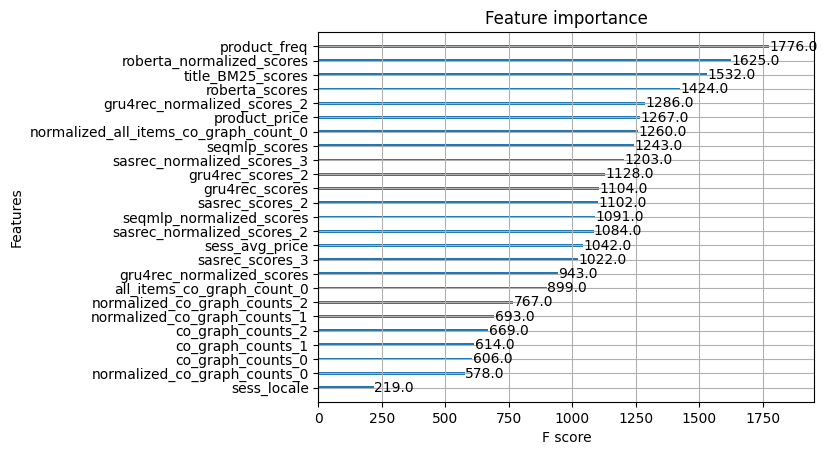

In [18]:
xgb.plot_importance(model)
plt.show()